In [117]:
from pathlib import Path

try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_ROOT = Path("/content/drive/MyDrive/research/vision_transformer")
    CHECKPOINT_DIR = DATA_ROOT/"vit_cifar_checkpoints"
    EXPERIMENT_DIR = DATA_ROOT/"experiments"
except:
    DATA_ROOT = Path.home()/"Desktop/research"
    CHECKPOINT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints"
    EXPERIMENT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/experiments"

if not DATA_ROOT.exists():
    DATA_ROOT.parent.mkdir(parents=True, exist_ok=True)
    print(f"DATA_ROOT created: {DATA_ROOT}")
else:
    print("DATA_ROOT exists: ", DATA_ROOT)
    
if not CHECKPOINT_DIR.exists():
    CHECKPOINT_DIR.parent.mkdir(parents=True, exist_ok=True)
    print(f"CHECKPOINT_DIR created : {CHECKPOINT_DIR}")
else:
    print("CHECKPOINT_DIR exists: ", CHECKPOINT_DIR)


DATA_ROOT exists:  /home/avishkar/Desktop/research
CHECKPOINT_DIR exists:  /home/avishkar/Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints


Files already downloaded and verified
Files already downloaded and verified
trainset : 50000, testset : 10000


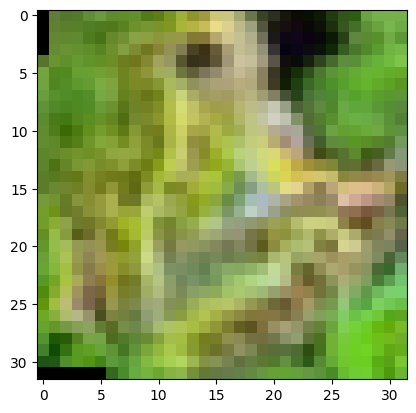

In [118]:
"""DATASET"""
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


torch.manual_seed(42)

DATASET = "cifar10"
NUM_WORKERS = 2
BATCH_SIZE = 32 

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Resize(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=7),
        transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    ]
)


train_dataset = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform= transform)
test_dataset = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform= transform)
print(f"trainset : {len(train_dataset)}, testset : {len(test_dataset)}")
classes = train_dataset.classes

# prepare
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

"""VISUALIZE DATA"""
import matplotlib.pyplot as plt

for i, (imgs, labels) in enumerate(train_loader):
    img = imgs[0]
    plt.imshow(img.T.cpu().numpy())
    plt.show()
    break

In [119]:
"""https://github.com/chingisooinar/AI_self-driving-car/blob/main/model/SimpleTransformer.py"""

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models

"""
Special Points
    - ResNet18 used from Positional Encoding
"""

config={
    "img_size":32,
    "patch_size":4,
    "seq_len" : (32//4)**2,
    "dropout":0.0,
}

class VisionTransformer(nn.Module):
    def __init__(self, config):
        super(VisionTransformer, self).__init__()
        self.seq_len = config["seq_len"]  #seq_length = (self.img_size // self.patch_size) ** 2 Most probably
        self.position_encoder = models.resnet18(pretrained=True)
        self.d_model = 512
        self.position_embedder = nn.Linear(in_features =1000, out_features = self.d_model, bias=True)
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=4, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2, norm=None) #nn.LayerNorm(512)
        
        self.reduce_combined = nn.Linear(in_features =self.d_model, out_features = 64, bias=True)
        
        self.classifier = nn.Linear(in_features = 64, out_features = 10, bias=True)
        # self.speed_predictor = nn.Linear(in_features = 64, out_features = 1, bias=True)
        
        
    def generate_square_subsequent_mask(self,sz: int):
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    
    def forward(self, x):
        x = x.reshape(-1, 3, 32, 32)
        x = F.relu(self.position_embedder(self.position_encoder(x)))
        x = x.reshape(-1, self.seq_len, self.d_model).permute(1, 0 ,2)
        
        # attn_mask = self.generate_square_subsequent_mask(x.shape[0]).cuda()
        attn_mask = self.generate_square_subsequent_mask(x.shape[0])
        
        fused_embedding = F.relu(self.transformer_encoder(x, mask=attn_mask))
        
        fused_embedding = fused_embedding.permute(1, 0, 2)
        fused_embedding = fused_embedding.reshape(-1, self.d_model)
        reduced = F.relu(self.reduce_combined(fused_embedding))
        
        angle = self.classifier(reduced)
        # speed = self.speed_predictor(reduced)
        
        return angle
                
        

In [120]:
"""UTILS"""
import json
from pathlib import Path

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "accuracies":accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    
    

In [121]:
import torch.optim as optim
import torch
import time

class Trainer:
    def __init__(self, model, optimizer, criterion, device, path=CHECKPOINT_DIR):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.path=path
        self.exp_dir = EXPERIMENT_DIR

    def train(self, train_loader, test_loader, num_epochs, save_model_every_n_epochs=0):
        train_losses = []
        test_losses = []
        accuracies = [] 
        start = time.time()
        for i in range(num_epochs):
            epo_start = time.time()
            train_loss = self.train_epoch(train_loader)
            accuracy, test_loss = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            ep_end = time.time()
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {(ep_end-epo_start):.4f}s")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != num_epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.model.state_dict(), i+1, train_losses, test_losses, accuracies, self.path)
        end = time.time()
        print(f"Total training time : {end- start}s")
        save_experiment(self.model, num_epochs, config, train_losses, test_losses, accuracies, self.exp_dir)

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()* len(imgs)
            break

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for i, (imgs, labels) in enumerate(test_loader):
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                predictions = self.model(imgs)
                
                loss = self.criterion(predictions, labels)
                total_loss += loss.item() * len(imgs)

                 # Calculate the accuracy
                predictions = torch.argmax(predictions, dim=1)
                correct += torch.sum(predictions == labels).item()
                break
        accuracy = correct / len(test_loader.dataset)
        avg_loss = total_loss / len(test_loader.dataset)
        return accuracy, avg_loss
         
config = {
    "img_size":32,
	"patch_size":4,
    "seq_len":32,
    # "seq_len":(32//4)**2,
	"num_channels":3,
	"num_layers":7,
	"num_heads":8,
	"embed_dim":768,
	"mlp_hidden_dim":4*768,
	"dropout":0.0,
	"num_classes":10,
    "lr":0.01,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "num_epochs":100,
    "exp_name":"vit_cifar10_mark2_100_epochs",
    "save_model_every":0
}   

def main():
    save_model_every_n_epochs = config["save_model_every"]
    model = VisionTransformer(config)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, criterion, device=config["device"])
    trainer.train(train_loader, test_loader, config["num_epochs"], save_model_every_n_epochs=save_model_every_n_epochs)

In [122]:
"""TRAINING"""
if __name__ == "__main__":
    main()

/home/avishkar/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avishkar/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/avishkar/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is Fal

torch.Size([32, 512])
torch.Size([32, 512])
Epoch: 1, Train loss: 0.0015, Test loss: 0.0084, Accuracy: 0.0004
/home/avishkar/Desktop/projects/deep_learning_essentials/vision_transformer/experiments/vit_cifar10_mark2_100_epochs/config.json created
/home/avishkar/Desktop/projects/deep_learning_essentials/vision_transformer/experiments/vit_cifar10_mark2_100_epochs/metrics.json created
model saved at path : /home/avishkar/Desktop/projects/deep_learning_essentials/vision_transformer/experiments/vit_cifar10_mark2_100_epochs/vit_cifar10_100.pth


In [123]:
"""VIS Loss, ACC"""

"""
def load_experiment(model ,exp_name, path):
    data = json.load(path/f"exp_name"/"metrics.json")
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    """


import matplotlib.pyplot as plt

model = ViT(config)
_, train_losses, test_losses, accuracies,_ = load_experiment(model, config["exp_name"], EXPERIMENT_DIR)
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

NameError: name 'ViT' is not defined